In [ ]:
from google.colab import drive
import os
import sys
import shutil
import subprocess

drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_DIR}/code"
DATA_PATH = f"{PROJECT_DIR}/data"
TEST_PATH = f"{PROJECT_DIR}/test"

In [ ]:
# 1. Clean existing code directory and clone fresh repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_DIR)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Code repository {'successfully' if result.returncode == 0 else 'failed'} to {CODE_PATH}{f', {result.stderr}' if result.returncode != 0 else ''}")

# 2. Display latest commit information
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%H|%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    hash_code, commit_time, commit_msg = commit_info.stdout.strip().split('|', 2)
    print(f"Latest commit:\n   Hash: {hash_code[:8]}\n   Time: {commit_time}\n   Message: {commit_msg}")

# 3. Add code path to Python sys.path so we can import our modules
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)
    print(f"✅ Added {CODE_PATH} to Python path")

# 4. Clear custom modules from cache
modules_to_clear = [

]

for base in modules_to_clear:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

print("✅ Modules reloaded!")

In [ ]:
%pip install diffusers accelerate safetensors transformers huggingface_hub

In [ ]:
# ========================================
# 模型下载Cell - 只运行一次，下载后可以注释掉
# ========================================

from huggingface_hub import snapshot_download
import os

MODEL_PATH = f"{PROJECT_DIR}/models"

def download_models():
    """下载并缓存instruct-pix2pix模型到Google Drive"""
    models_config = {
        "instruct-pix2pix": "timbrooks/instruct-pix2pix"
    }

    print("🚀 Starting model download process...")
    print(f"📁 Model cache directory: {MODEL_PATH}")

    # 创建模型目录
    os.makedirs(MODEL_PATH, exist_ok=True)

    for model_name, model_id in models_config.items():
        model_dir = f"{MODEL_PATH}/{model_name}"

        if not os.path.exists(model_dir):
            print(f" Downloading {model_name}...")
            try:
                snapshot_download(
                    repo_id=model_id,
                    local_dir=model_dir
                )
                print(f"✅ {model_name} downloaded successfully")
            except Exception as e:
                print(f"❌ Failed to download {model_name}: {e}")
        else:
            print(f"✅ {model_name} already cached")

    print(" Model ready!")

# 执行下载
download_models()

 Loading model from: /content/drive/MyDrive/SVGEditor/models/instruct-pix2pix


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Model loaded from cache successfully!
 Loading image from: /content/drive/MyDrive/SVGEditor/data/image_point_optim_500.png
✅ Image loaded: (512, 512)
🎨 Processing with prompt: '
original picture is an apple, remove the leafs, do not change other parts of the picture, follow the drawing style of the original picture.
'


  0%|          | 0/10 [00:00<?, ?it/s]

✅ Demo completed!
 Result image size: (512, 512)


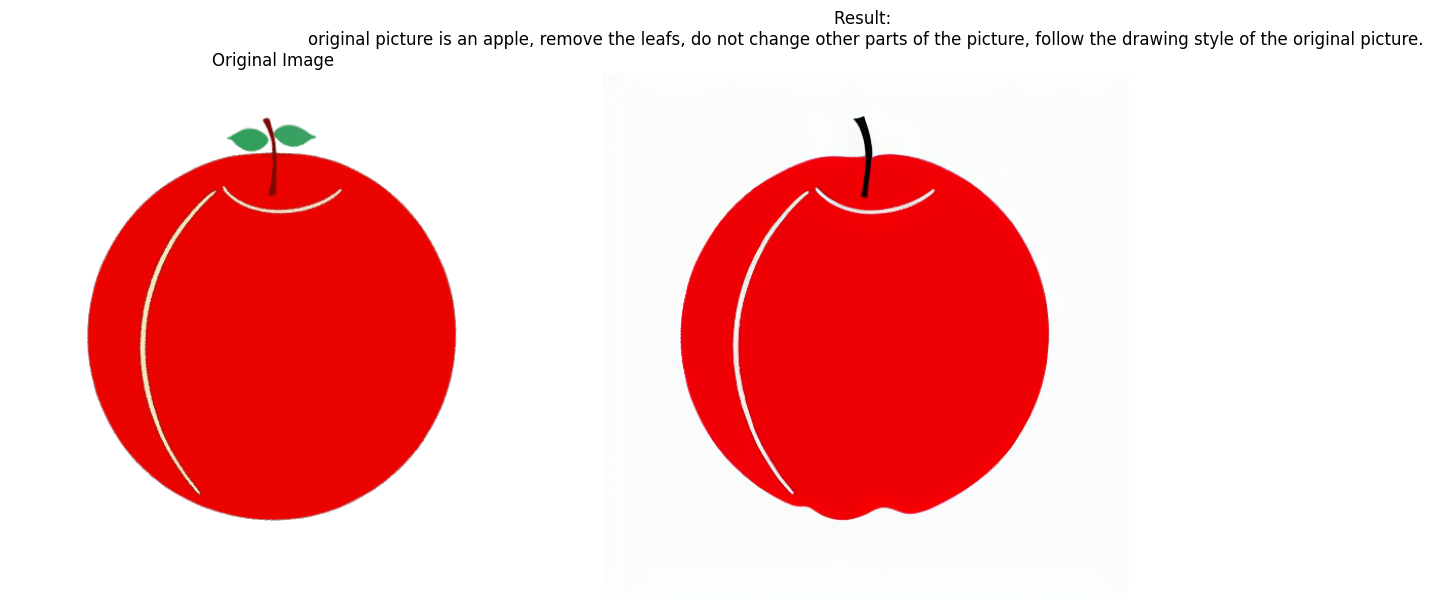


📸 Result image:


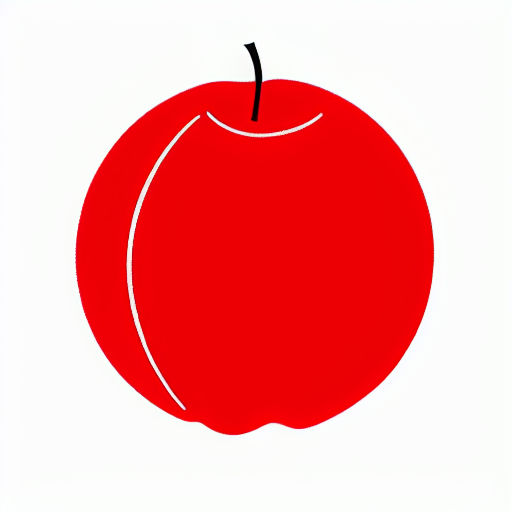

In [42]:
# ========================================
# 从本地缓存加载模型并运行demo
# ========================================

import PIL
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import matplotlib.pyplot as plt

# 从本地缓存加载模型
model_path = f"{MODEL_PATH}/instruct-pix2pix"
print(f" Loading model from: {model_path}")

pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    safety_checker=None
)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

print("✅ Model loaded from cache successfully!")

# 从Google Drive读取示例图片
image_path = f"{PROJECT_DIR}/data/image_point_optim_500.png"
print(f" Loading image from: {image_path}")

# 检查文件是否存在
if os.path.exists(image_path):
    image = PIL.Image.open(image_path)
    image = image.convert("RGB")
    print(f"✅ Image loaded: {image.size}")
else:
    print(f"❌ Image not found at: {image_path}")
    print("Please make sure the image is uploaded to Google Drive")

# 运行demo
prompt = """
original picture is an apple, remove the leafs, do not change other parts of the picture, follow the drawing style of the original picture.
"""
print(f"🎨 Processing with prompt: '{prompt}'")

images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=2).images
result_image = images[0]

print("✅ Demo completed!")
print(f" Result image size: {result_image.size}")

# 显示原图和结果图对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(result_image)
axes[1].set_title(f"Result: {prompt}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 也可以直接显示结果图（Colab会自动显示）
print("\n📸 Result image:")
result_image